In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime

from FIESTA_functions import *
from HARPS_N_functions import *

#----------------------------------
# Read data
#----------------------------------

v_grid  = np.loadtxt('./data_v4/v_grid.txt')
CCF     = np.loadtxt('./data_v4/CCF.txt')
σCCF   = np.loadtxt('./data_v4/σCCF.txt')
bjd     = np.loadtxt('./data_v4/bjd.txt')
rv      = np.loadtxt('./data_v4/rv.txt')
σrv     = np.loadtxt('./data_v4/σrv.txt')
idx_rej = np.array(np.loadtxt('idx_rej'), dtype=bool)

In [160]:
import celerite
from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from datetime import datetime
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days +1)):
        yield start_date + timedelta(n)

# log-likehiood as a funciton of S0_1, S0_2, ...

In [4]:
1/2899.022e-6/60, 1/3033.754e-6/60, 1/3168.618e-6/60, 1/3303.520e-6/60


(5.749065259479462, 5.493743614896483, 5.259916678711876, 5.045123585347347)

In [5]:
1/2828.150e-6/60, 1/2963.322e-6/60, 1/3098.140e-6/60, 1/3233.139e-6/60

(5.89313390968183, 5.6243184732090095, 5.3795718291189765, 5.154949003635992)

Update the GP funcion: freeze S0 hypeeparameters except S0_2 and S0_4.

In [148]:
import random
import george
from george import kernels
from sklearn.model_selection import KFold

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)        

def GP(t, y, yerr, S0, S0_2, S0_4, Q):
    '''
        6/8 frequency modes
    '''
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/8), np.log(2*np.pi/2))) 
    k01 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2899.022e-6/60)), bounds=bounds) # 2899.022e-3, 3033.754e-3, 3168.618e-3, 3303.520
    k02 = terms.SHOTerm(log_S0=np.log(S0_2), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3033.754e-6/60)), bounds=bounds)
    # k03 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3168.618e-6/60)), bounds=bounds)
    k04 = terms.SHOTerm(log_S0=np.log(S0_4), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3303.520e-6/60)), bounds=bounds)
    
    # k11 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2828.150e-6/60)), bounds=bounds) # 2828.150e-3, 2963.322e-3, 3098.140e-3
    # k12 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2963.322e-6/60)), bounds=bounds)
    # k13 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3098.140e-6/60)), bounds=bounds)    
    # k14 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3233.139e-6/60)), bounds=bounds)    
    
    k01.freeze_parameter("log_Q")
    k01.freeze_parameter("log_omega0")
    k02.freeze_parameter("log_Q")
    k02.freeze_parameter("log_S0")        #new
    k02.freeze_parameter("log_omega0")
    # k03.freeze_parameter("log_Q")
    # k03.freeze_parameter("log_omega0")
    k04.freeze_parameter("log_Q")
    k04.freeze_parameter("log_S0")        #new    
    k04.freeze_parameter("log_omega0")
    # k11.freeze_parameter("log_Q")
    # k11.freeze_parameter("log_omega0")
    # k12.freeze_parameter("log_Q")
    # k12.freeze_parameter("log_omega0")    
    # k13.freeze_parameter("log_Q")
    # k13.freeze_parameter("log_omega0")    
    # k14.freeze_parameter("log_Q")
    # k14.freeze_parameter("log_omega0")
    # kernel = k01 + k02 + k03 + k11 + k12 + k13
    # kernel = k01 + k02 + k03 + k04 + k11 + k12 + k13 + k14
    kernel = k01 + k02 + k04

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)
    
    return gp

In [149]:
date = datetime(2021, 5, 28)
T1 = pyasl.jdcnv(date)
idx_bjd = (bjd>T1) & (bjd<T1+1) & (~idx_rej)

t = (bjd[idx_bjd]-min(bjd[idx_bjd]))*24*60
y = rv[idx_bjd] - np.mean(rv[idx_bjd])
reg = LinearRegression().fit(t.reshape((-1, 1)), y)
y = y - reg.predict(t.reshape((-1, 1)))
yerr = σrv[idx_bjd]

Q = 6
w0 = 2*np.pi/5
S0 = np.var(y) / (w0 * Q)

In [150]:
N1 = 30
N2 = 30
S0_2 = np.linspace(0.01, 0.1, N1)
S0_4 = np.linspace(0.01, 0.1, N2)
S0_1 = np.zeros((N1, N2))
ll_matrix = np.zeros((N1, N2))

for i in range(N1):
    for j in range(N2):
        # if ~( ((S0_2[i]+S0_4[j])<0.04) | ((S0_2[i]+S0_4[j])>0.15)):
            gp = GP(t, y, yerr, S0, S0_2[i], S0_4[j], Q)
            ll_matrix[i,j] = gp.log_likelihood(y)
            S0_1[i,j] = np.exp(gp.get_parameter('kernel:terms[0]:log_S0'))

ll_matrix[ll_matrix==0]=min(ll_matrix[ll_matrix!=0])
X, Y = np.meshgrid(S0_2, S0_4)
Z = ll_matrix

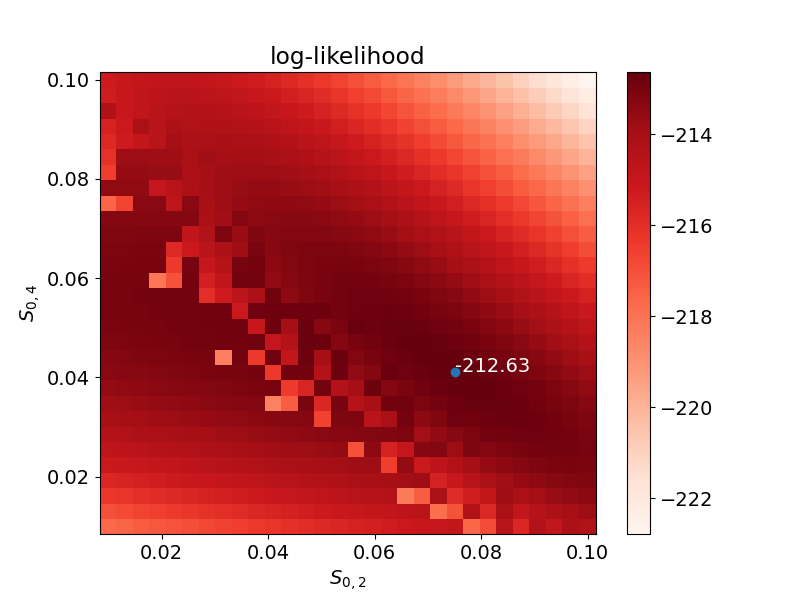

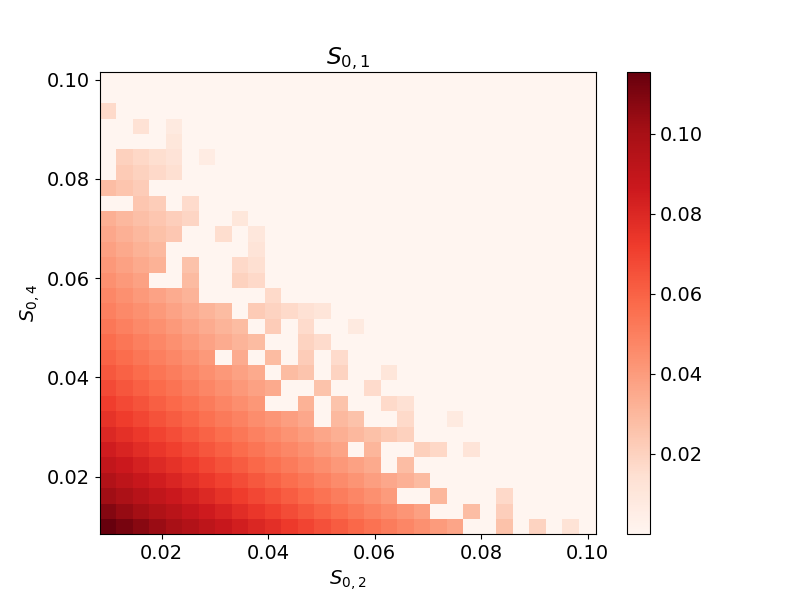

In [151]:
fig = plt.figure(figsize=(8,6))
plt.pcolor(S0_2, S0_4, np.transpose(Z), cmap=plt.cm.get_cmap('Reds'))

plt.title("log-likelihood")   
plt.xlabel('$S_{0,2}$')
plt.ylabel('$S_{0,4}$')
max_loc = np.where(ll_matrix == ll_matrix.max())
plt.plot(S0_2[max_loc[0]][0], S0_4[max_loc[1]][0], 'o')
plt.text(S0_2[max_loc[0]][0], S0_4[max_loc[1]][0], f'{ll_matrix.max():.2f}', color='w')
plt.colorbar()
plt.show()    

fig = plt.figure(figsize=(8,6))
plt.pcolor(S0_2, S0_4, np.transpose(S0_1), cmap=plt.cm.get_cmap('Reds'))
plt.title('$S_{0,1}$')   
plt.xlabel('$S_{0,2}$')
plt.ylabel('$S_{0,4}$')
plt.colorbar()
plt.show()    

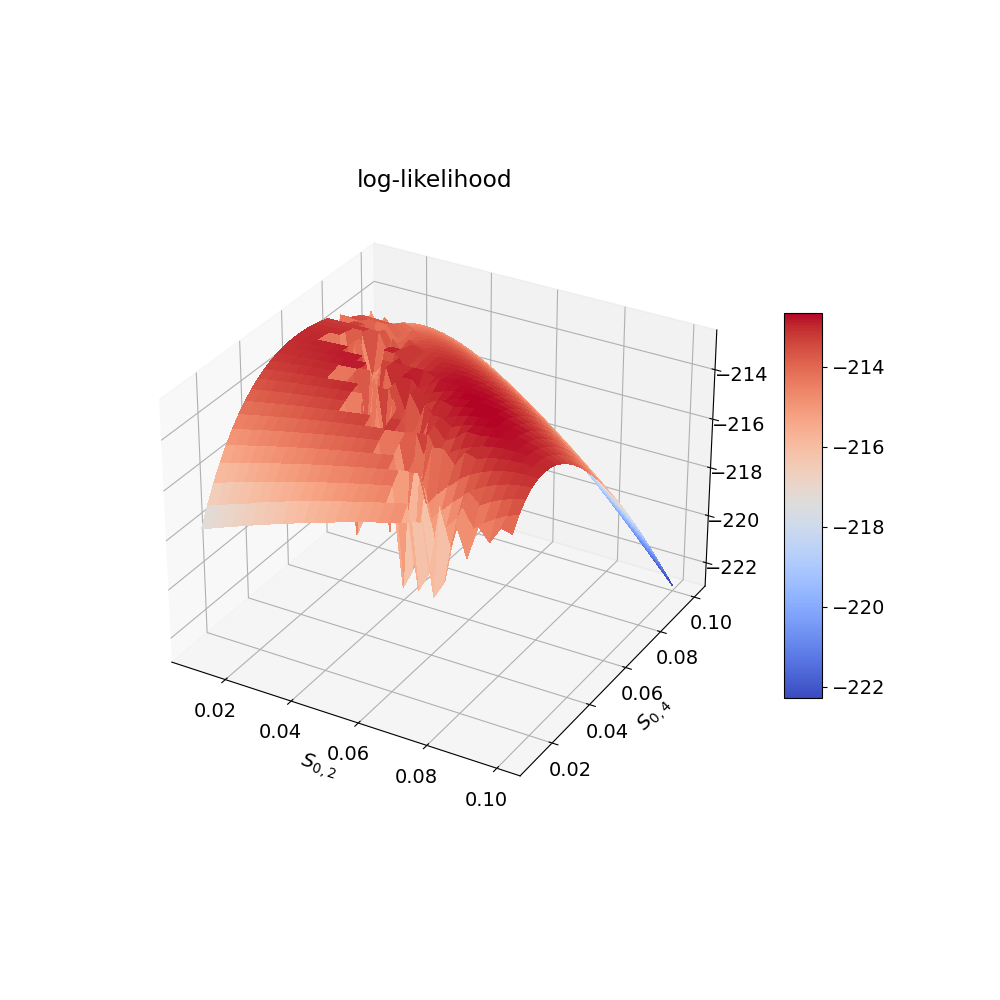

In [109]:
%matplotlib widget
from matplotlib import cm

plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, np.transpose(Z), rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_title('log-likelihood')   
ax.set_xlabel('$S_{0,2}$')
ax.set_ylabel('$S_{0,4}$')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

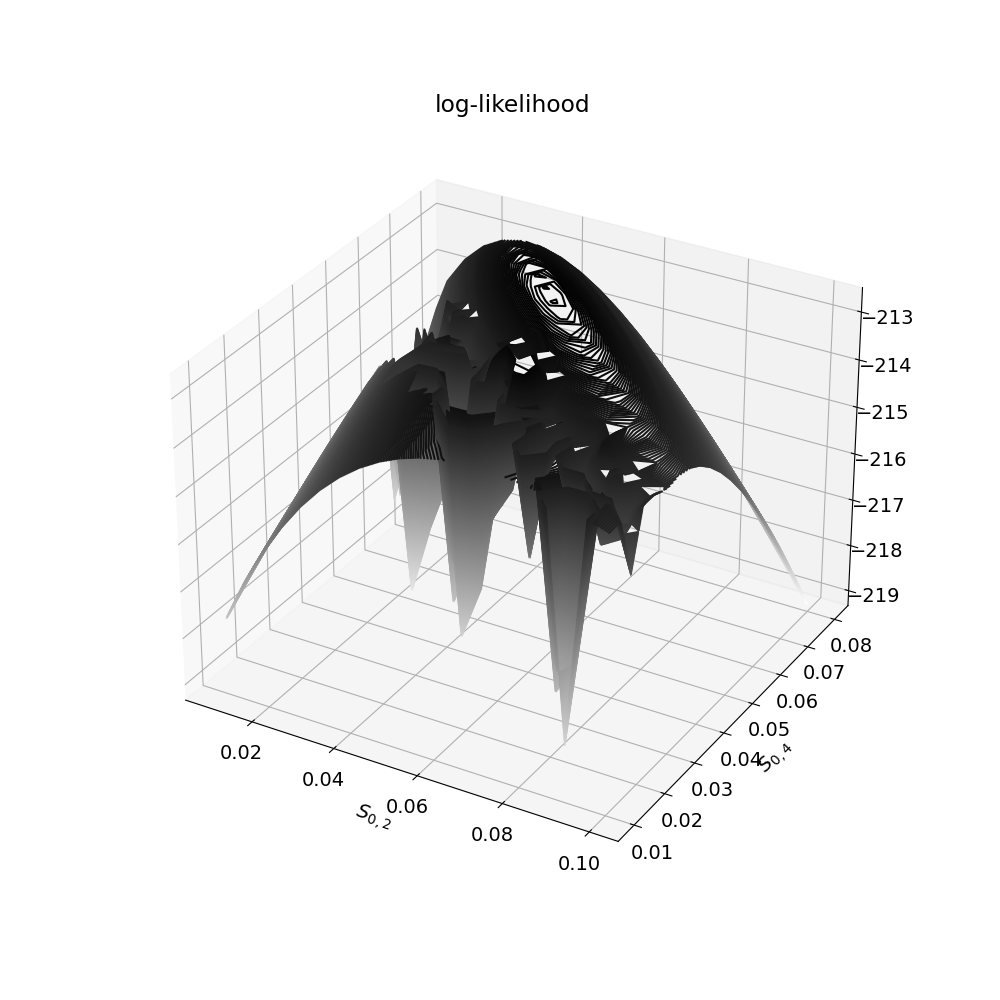

In [20]:
%matplotlib widget
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 500, cmap='binary')
ax.set_title('log-likelihood')   
ax.set_xlabel('$S_{0,2}$')
ax.set_ylabel('$S_{0,4}$')
plt.show()

In [100]:
gp.get_parameter_dict(), np.exp(gp.get_parameter('kernel:terms[0]:log_S0'))


(OrderedDict([('kernel:terms[0]:log_S0', -15.0)]), 3.059023205018258e-07)

In [23]:
np.where(ll_matrix == ll_matrix.max()) 

(array([13]), array([9]))

In [24]:
ll_matrix.max()

-212.6321436023057

In [26]:
ll_matrix[13,9]

-212.6321436023057

In [27]:
S0_2[13], S0_4[9]

(0.07157894736842106, 0.04315789473684211)

In [20]:
S0_2

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

In [155]:
def GP(t, y, yerr, S0_1, S0_2, S0_4, Q):
    '''
        6/8 frequency modes
    '''
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(np.log(2*np.pi/8), np.log(2*np.pi/2))) 
    k01 = terms.SHOTerm(log_S0=np.log(S0_1), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2899.022e-6/60)), bounds=bounds) # 2899.022e-3, 3033.754e-3, 3168.618e-3, 3303.520
    k02 = terms.SHOTerm(log_S0=np.log(S0_2), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3033.754e-6/60)), bounds=bounds)
    # k03 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3168.618e-6/60)), bounds=bounds)
    k04 = terms.SHOTerm(log_S0=np.log(S0_4), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3303.520e-6/60)), bounds=bounds)
    
    # k11 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2828.150e-6/60)), bounds=bounds) # 2828.150e-3, 2963.322e-3, 3098.140e-3
    # k12 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/2963.322e-6/60)), bounds=bounds)
    # k13 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3098.140e-6/60)), bounds=bounds)    
    # k14 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(2*np.pi/(1/3233.139e-6/60)), bounds=bounds)    

    k01.freeze_parameter("log_S0")        #new
    k01.freeze_parameter("log_Q")
    k01.freeze_parameter("log_omega0")
    k02.freeze_parameter("log_Q")
    k02.freeze_parameter("log_S0")        #new
    k02.freeze_parameter("log_omega0")
    # k03.freeze_parameter("log_Q")
    # k03.freeze_parameter("log_omega0")
    k04.freeze_parameter("log_Q")
    k04.freeze_parameter("log_S0")        #new    
    k04.freeze_parameter("log_omega0")
    # k11.freeze_parameter("log_Q")
    # k11.freeze_parameter("log_omega0")
    # k12.freeze_parameter("log_Q")
    # k12.freeze_parameter("log_omega0")    
    # k13.freeze_parameter("log_Q")
    # k13.freeze_parameter("log_omega0")    
    # k14.freeze_parameter("log_Q")
    # k14.freeze_parameter("log_omega0")
    # kernel = k01 + k02 + k03 + k11 + k12 + k13
    # kernel = k01 + k02 + k03 + k04 + k11 + k12 + k13 + k14
    kernel = k01 + k02 + k04

    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)  # You always need to call compute once.

    # initial_params = gp.get_parameter_vector()
    # bounds = gp.get_parameter_bounds()

    # r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    # gp.set_parameter_vector(r.x)
    
    return gp

In [158]:
N = 100
N2 = 30
N4 = 30
S0_1 = np.linspace(0.001, 0.1, N)
S0_2 = np.linspace(0.01, 0.1, N2)
S0_4 = np.linspace(0.01, 0.1, N4)


for n in range(N):

    ll_matrix = np.zeros((N2, N4))

    for i in range(N1):
        for j in range(N2):
            gp = GP(t, y, yerr, S0_1[n], S0_2[i], S0_4[j], Q)
            ll_matrix[i,j] = gp.log_likelihood(y)

    X, Y = np.meshgrid(S0_2, S0_4)
    Z = ll_matrix

    fig = plt.figure(figsize=(8,6))
    plt.pcolor(S0_2, S0_4, np.transpose(Z), cmap=plt.cm.get_cmap('Reds'))

    plt.title('$S_{0,1}$ = ' + f'{S0_1[n]:.3f}')   
    plt.xlabel('$S_{0,2}$')
    plt.ylabel('$S_{0,4}$')
    max_loc = np.where(ll_matrix == ll_matrix.max())
    plt.plot(S0_2[max_loc[0]][0], S0_4[max_loc[1]][0], 'o')
    plt.text(S0_2[max_loc[0]][0], S0_4[max_loc[1]][0], f'{ll_matrix.max():.2f}', color='w')
    plt.colorbar()
    plt.savefig('./ll_matrix/ll_matrix_S0_1_' + f'{S0_1[n]:.3f}' + '.png')
    plt.close()

In [159]:
import cv2

img_array = []
for n in range(N):
    file = './ll_matrix/ll_matrix_S0_1_' + f'{S0_1[n]:.3f}' + '.png'
    img = cv2.imread(file)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('ll_matrix.avi', cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [4]:
np.median(σrv)
σrv.shape

(31795,)